##Data preprocessing

Before training, perform simple preprocessing on the data set and check the basic format of the data.

In [1]:
# Import package
import time
import numpy as np
import wfdb
import ast
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pylab import mpl
from scipy.fftpack import fft, ifft 
from scipy import signal
from biosppy.signals import ecg

## Read file


In [2]:
#Set the read file path
path = 'D:/Test Jupyter/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/ptbxl/'

sampling_rate = 100

In [3]:

# Read the file and convert tags
Y = pd.read_csv(path+'ptbxl_database.csv', index_col='ecg_id')
Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))

In [4]:
Y.head

<bound method NDFrame.head of         patient_id   age  sex  height  weight  nurse  site      device  \
ecg_id                                                                   
1          15709.0  56.0    1     NaN    63.0    2.0   0.0   CS-12   E   
2          13243.0  19.0    0     NaN    70.0    2.0   0.0   CS-12   E   
3          20372.0  37.0    1     NaN    69.0    2.0   0.0   CS-12   E   
4          17014.0  24.0    0     NaN    82.0    2.0   0.0   CS-12   E   
5          17448.0  19.0    1     NaN    70.0    2.0   0.0   CS-12   E   
...            ...   ...  ...     ...     ...    ...   ...         ...   
21833      17180.0  67.0    1     NaN     NaN    1.0   2.0  AT-60    3   
21834      20703.0  93.0    0     NaN     NaN    1.0   2.0  AT-60    3   
21835      19311.0  59.0    1     NaN     NaN    1.0   2.0  AT-60    3   
21836       8873.0  64.0    1     NaN     NaN    1.0   2.0  AT-60    3   
21837      11744.0  68.0    0     NaN     NaN    1.0   2.0  AT-60    3   

       

In [5]:
Y.scp_codes

ecg_id
1                 {'NORM': 100.0, 'LVOLT': 0.0, 'SR': 0.0}
2                             {'NORM': 80.0, 'SBRAD': 0.0}
3                               {'NORM': 100.0, 'SR': 0.0}
4                               {'NORM': 100.0, 'SR': 0.0}
5                               {'NORM': 100.0, 'SR': 0.0}
                               ...                        
21833    {'NDT': 100.0, 'PVC': 100.0, 'VCLVH': 0.0, 'ST...
21834             {'NORM': 100.0, 'ABQRS': 0.0, 'SR': 0.0}
21835                           {'ISCAS': 50.0, 'SR': 0.0}
21836                           {'NORM': 100.0, 'SR': 0.0}
21837                           {'NORM': 100.0, 'SR': 0.0}
Name: scp_codes, Length: 21837, dtype: object

In [6]:
def load_raw_data(df, sampling_rate, path):
    if sampling_rate == 100:
        data = [wfdb.rdsamp(path+f) for f in df.filename_lr]
    else:
        data = [wfdb.rdsamp(path+f) for f in df.filename_hr]
    data = np.array([signal for signal, meta in data])
    return data

In [7]:

# Get original signal data
X = load_raw_data(Y, sampling_rate, path)

In [8]:
X.shape

(21837, 1000, 12)

In [4]:

# Get diagnostic information in scp_statements.csv
agg_df = pd.read_csv(path+'scp_statements.csv', index_col=0)

In [9]:
agg_df.head

<bound method NDFrame.head of                                              description  diagnostic  form  \
NDT                       non-diagnostic T abnormalities         1.0   1.0   
NST_                             non-specific ST changes         1.0   1.0   
DIG                                     digitalis-effect         1.0   1.0   
LNGQT                                   long QT-interval         1.0   1.0   
NORM                                          normal ECG         1.0   NaN   
...                                                  ...         ...   ...   
BIGU   bigeminal pattern (unknown origin, SV or Ventr...         NaN   NaN   
AFLT                                      atrial flutter         NaN   NaN   
SVTAC                       supraventricular tachycardia         NaN   NaN   
PSVT             paroxysmal supraventricular tachycardia         NaN   NaN   
TRIGU  trigeminal pattern (unknown origin, SV or Vent...         NaN   NaN   

       rhythm diagnostic_class di

In [5]:
agg_df = agg_df[agg_df.diagnostic == 1]

In [6]:
def diagnostic_class(scp):
    res = set()
    for k in scp.keys():
        if k in agg_df.index:
            res.add(agg_df.loc[k].diagnostic_class)
    return list(res)

In [7]:
def aggregate_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))

In [8]:
Y['scp_classes'] = Y.scp_codes.apply(diagnostic_class)

In [9]:
Z = pd.DataFrame(0, index=Y.index, columns=['NORM', 'MI', 'STTC', 'CD', 'HYP'], dtype='int')
for i in Z.index:
    for k in Y.loc[i].scp_classes:
        Z.loc[i, k] = 1

Z

,NORM,MI,STTC,CD,HYP
ecg_id,,,,,
1,1,0,0,0,0
2,1,0,0,0,0
3,1,0,0,0,0
4,1,0,0,0,0
5,1,0,0,0,0
...,...,...,...,...,...
21833,0,0,1,0,0
21834,1,0,0,0,0
21835,0,0,1,0,0


In [16]:
Z.loc[39]

NORM    0
MI      1
STTC    1
CD      0
HYP     0
Name: 39, dtype: int32

In [10]:
#Add diagnostic information
Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_diagnostic)

In [11]:
Y[['scp_codes', 'scp_classes', 'diagnostic_superclass']]

,scp_codes,scp_classes,diagnostic_superclass
ecg_id,,,
1,"{'NORM': 100.0, 'LVOLT': 0.0, 'SR': 0.0}",[NORM],[NORM]
2,"{'NORM': 80.0, 'SBRAD': 0.0}",[NORM],[NORM]
3,"{'NORM': 100.0, 'SR': 0.0}",[NORM],[NORM]
4,"{'NORM': 100.0, 'SR': 0.0}",[NORM],[NORM]
5,"{'NORM': 100.0, 'SR': 0.0}",[NORM],[NORM]
...,...,...,...
21833,"{'NDT': 100.0, 'PVC': 100.0, 'VCLVH': 0.0, 'ST...",[STTC],[STTC]
21834,"{'NORM': 100.0, 'ABQRS': 0.0, 'SR': 0.0}",[NORM],[NORM]
21835,"{'ISCAS': 50.0, 'SR': 0.0}",[STTC],[STTC]


In [12]:
check_y=Y.loc[Y.index == 39, ['scp_codes', 'scp_classes', 'diagnostic_superclass']]
check_y

,scp_codes,scp_classes,diagnostic_superclass
ecg_id,,,
39,"{'IMI': 15.0, 'LNGQT': 100.0, 'NST_': 100.0, '...","[MI, STTC]","[MI, STTC]"


In [18]:
Y.diagnostic_superclass.value_counts()

[NORM]                 9083
[MI]                   2538
[STTC]                 2406
[CD]                   1709
[CD, MI]               1302
[STTC, HYP]             783
[STTC, MI]              602
[HYP]                   536
[STTC, CD]              472
[NORM, CD]              407
[]                      407
[STTC, HYP, MI]         340
[CD, HYP]               238
[HYP, MI]               183
[STTC, HYP, CD]         131
[STTC, CD, MI]          118
[STTC, MI, CD]          105
[CD, MI, HYP]            98
[STTC, HYP, MI, CD]      98
[STTC, CD, HYP]          80
[HYP, CD]                62
[STTC, CD, MI, HYP]      51
[NORM, STTC]             28
[STTC, MI, HYP]          22
[HYP, MI, CD]            19
[STTC, MI, HYP, CD]       9
[STTC, NORM, CD]          5
[NORM, CD, HYP]           2
[NORM, HYP]               2
[NORM, CD, MI, HYP]       1
Name: diagnostic_superclass, dtype: int64

In [19]:
Y.columns

Index(['patient_id', 'age', 'sex', 'height', 'weight', 'nurse', 'site',
       'device', 'recording_date', 'report', 'scp_codes', 'heart_axis',
       'infarction_stadium1', 'infarction_stadium2', 'validated_by',
       'second_opinion', 'initial_autogenerated_report', 'validated_by_human',
       'baseline_drift', 'static_noise', 'burst_noise', 'electrodes_problems',
       'extra_beats', 'pacemaker', 'strat_fold', 'filename_lr', 'filename_hr',
       'scp_classes', 'diagnostic_superclass'],
      dtype='object')


## Plot to view original data

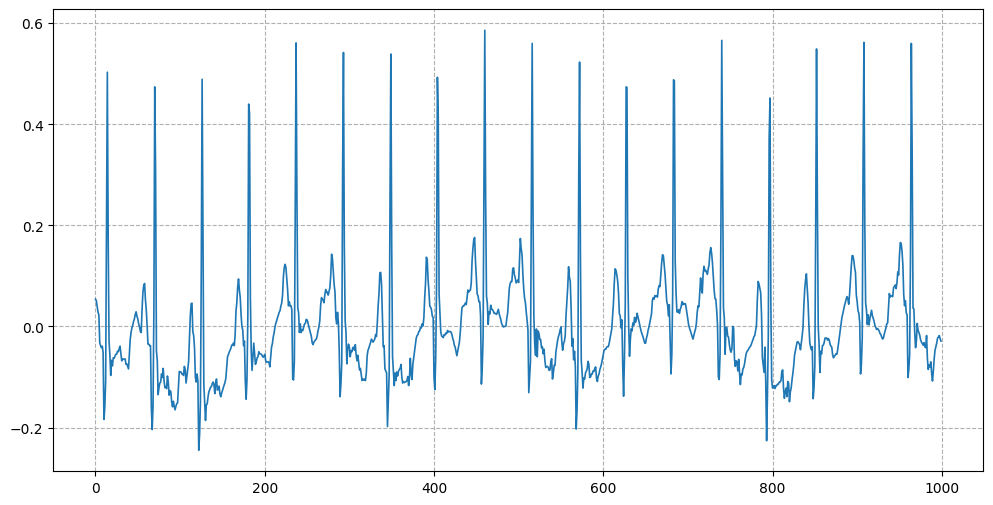

In [18]:
plt.rcParams['figure.figsize'] = (12,6) 
plt.figure()
plt.plot(X[262][:,2], linewidth=1.2)
plt.grid(linestyle='--')
# plt.yticks([])
plt.show()

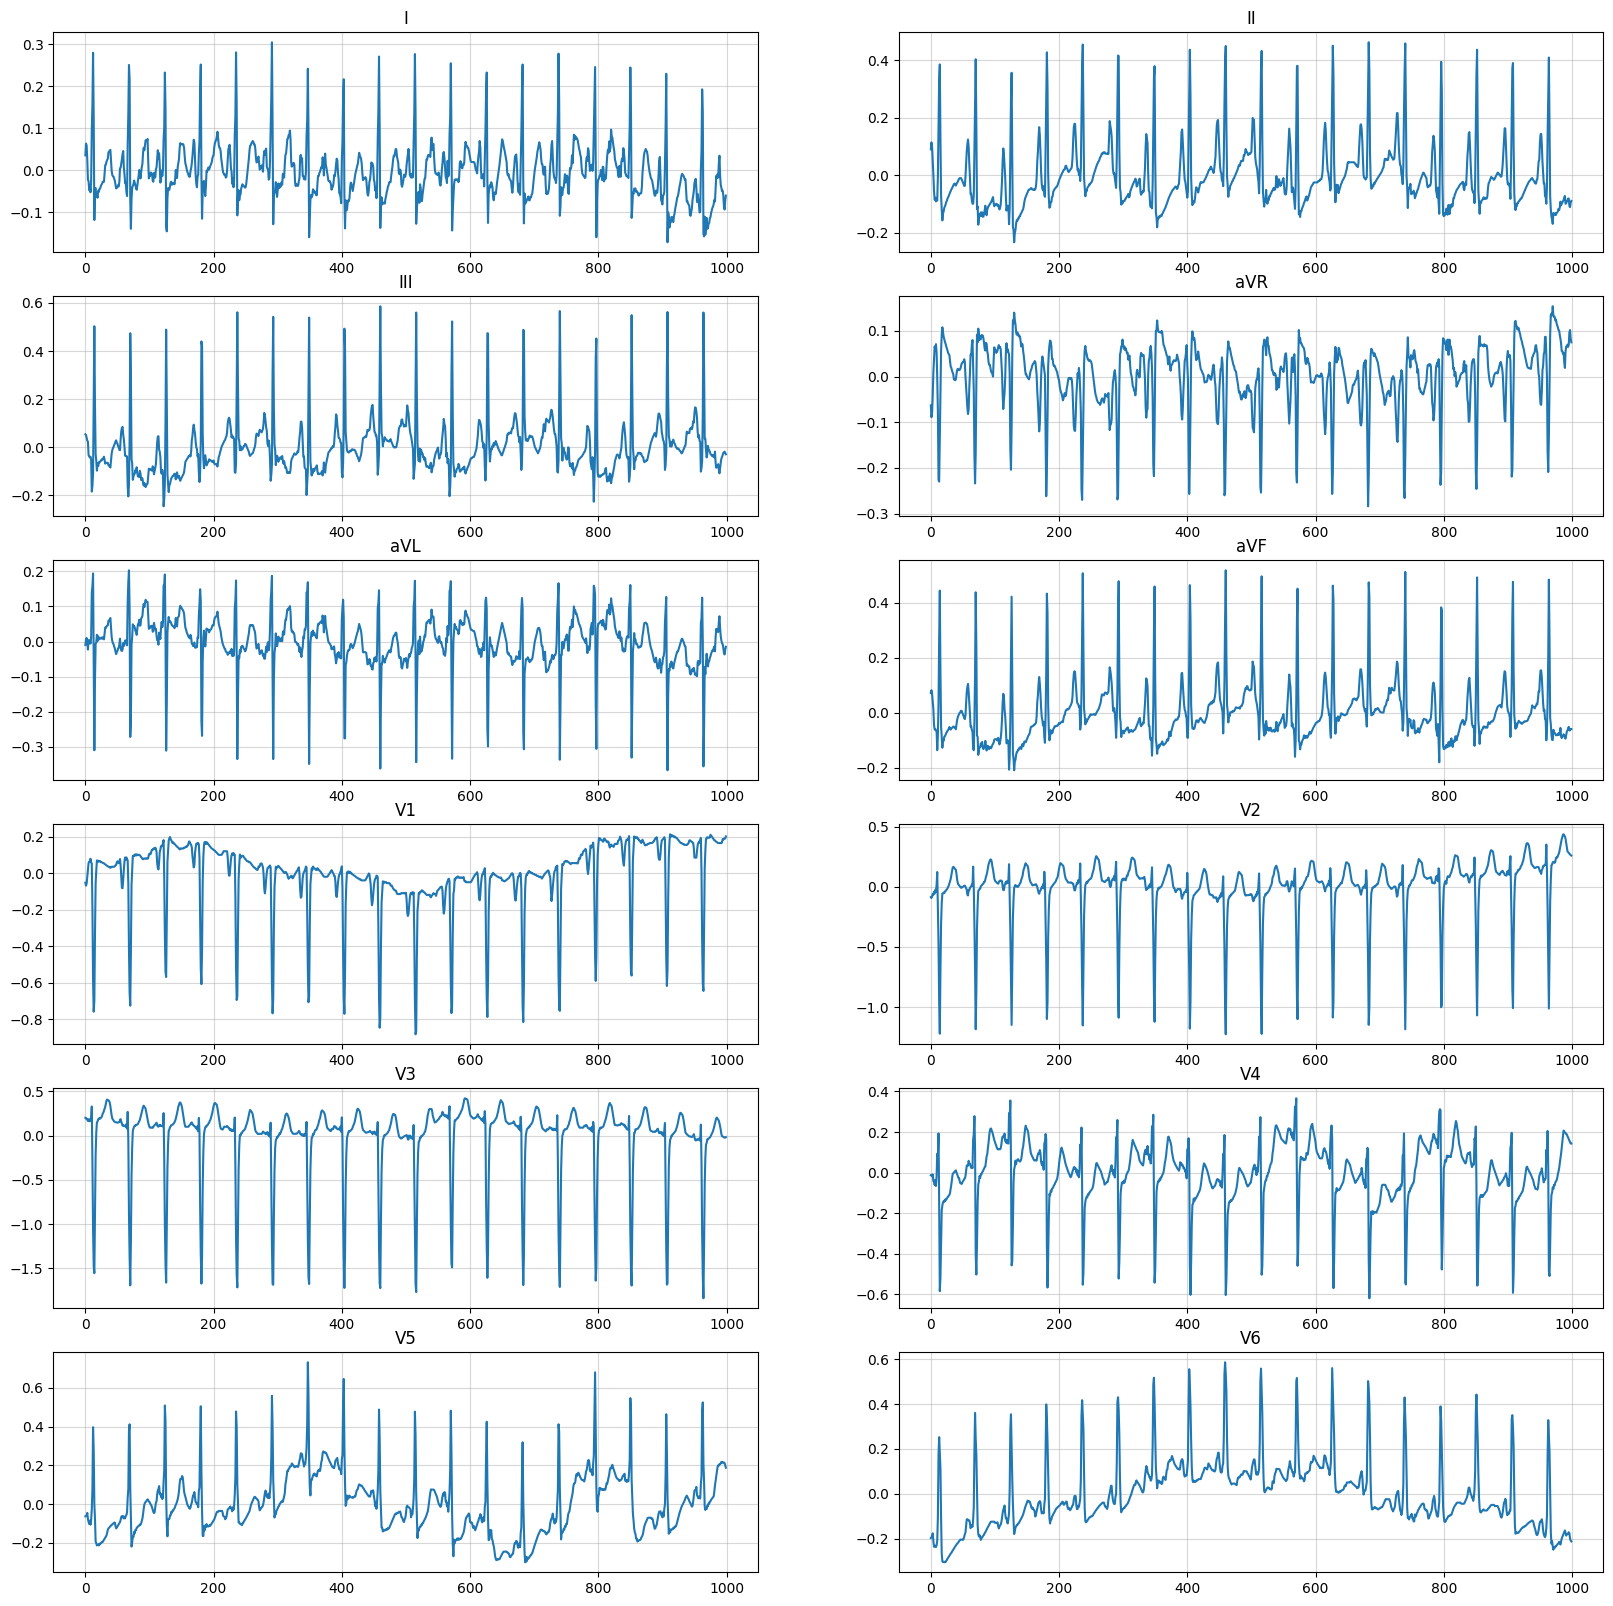

In [11]:
titles = ["I", "II", "III", "aVR", "aVL", "aVF", "V1", "V2", "V3", "V4", "V5", "V6"]
plt.rcParams['figure.figsize'] = (20.0, 20.0)
plt.rcParams["axes.grid"] = True
plt.rcParams["grid.linestyle"] = (0.1,0.1)
plt.figure()
for i in range(12):
    plt.subplot(6, 2, i+1)
    plt.plot(X[262,:,i])
    plt.title(titles[i])
plt.show()


## ECG filtering to remove baseline drift and segmentation

In [12]:
def np_move_avg(a,n,mode="same"):
    return(np.convolve(a, np.ones((n,))/n, mode=mode))


### Five-point smoothing filter

In [13]:
ecg_original = X[40][:,1]
ecg_filtered = np_move_avg(ecg_original, 5)

In [14]:
#fft transform to view the spectrum
def ecg_fft_ana(ecg_original, sampling_rate):
    fs = sampling_rate
    ts = 1.0/fs
    t = np.arange(0, 1, ts)
    n = len(ecg_original)
    k = np.arange(n)
    t = n/fs
    frq = k/t
    frq = frq[range(int(n/2))]
    fft_ecg = np.abs(fft(ecg_original))[range(int(n/2))]
    return frq, fft_ecg

In [16]:
def show_spec_dif(ecg_original, ecg_filtered, title1="title1", title2 = "title2"):
    plt.rcParams['figure.figsize'] = (20.0, 10.0)
    plt.rcParams["axes.grid"] = True
    plt.rcParams["grid.linestyle"] = (0.1,0.1)
    plt.rcParams['axes.titlesize'] = 16
    frq, fft_ecg = ecg_fft_ana(ecg_original, sampling_rate)
    frq_filtered, fft_ecg_filtered = ecg_fft_ana(ecg_filtered, sampling_rate)
    plt.figure()
    plt.subplot(221)
    plt.plot(ecg_original[:100])
    plt.title(title1)
    plt.subplot(222)
    plt.plot(frq,fft_ecg)
    plt.title(title1 + '`s spectrum')
    plt.subplot(223)
    plt.plot(ecg_filtered[:100])
    plt.title(title2)
    plt.subplot(224)
    plt.plot(frq_filtered, fft_ecg_filtered)
    plt.title(title2 + '`s spectrum')
    plt.show()

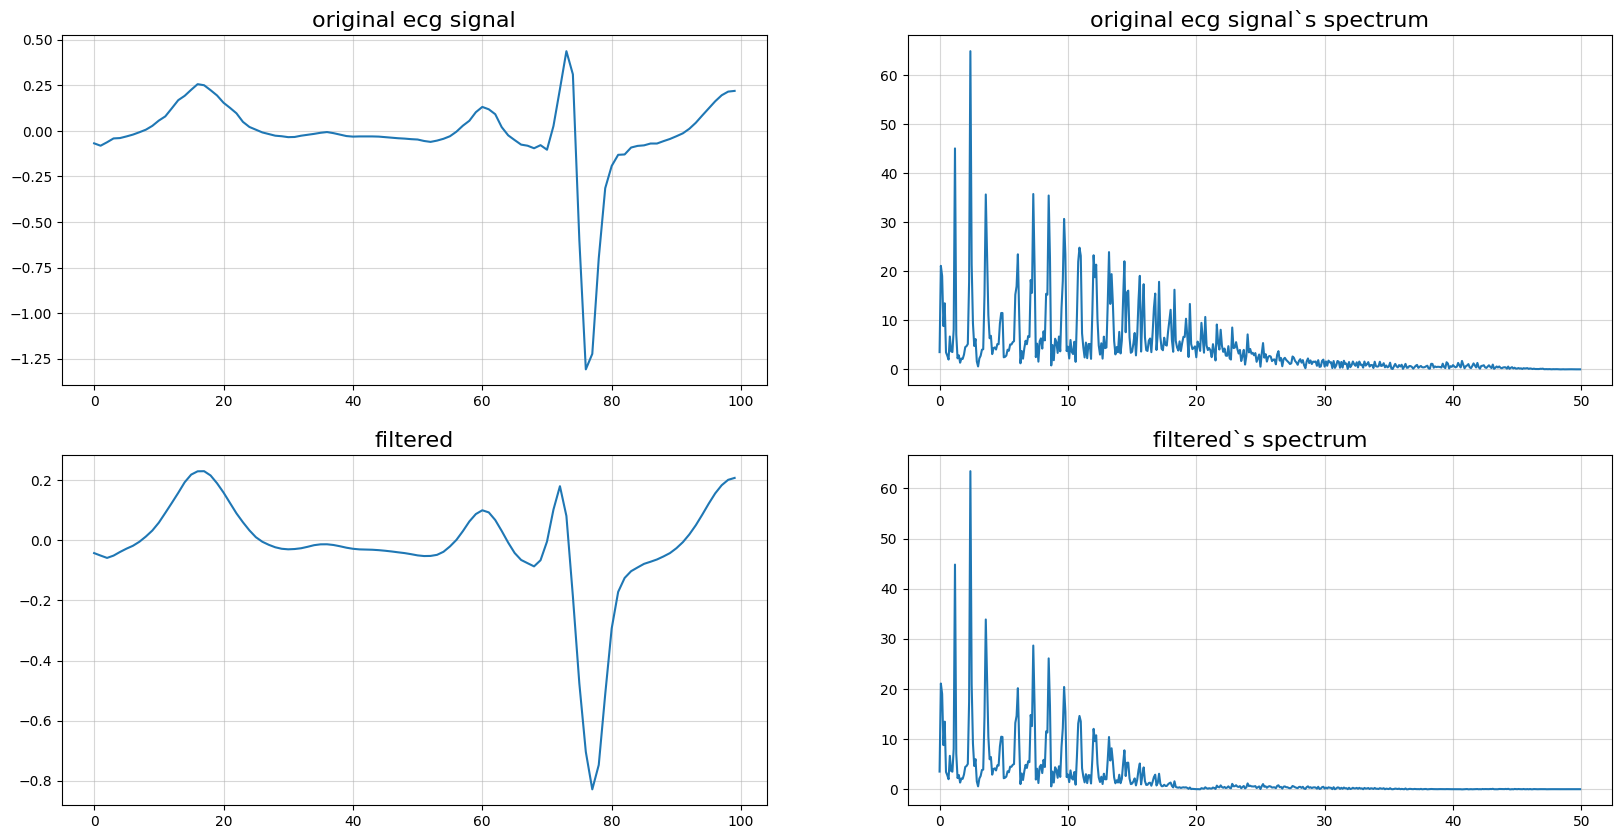

In [17]:
show_spec_dif(ecg_original, ecg_filtered, 'original ecg signal', 'filtered')

### New test with neurokit clean

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >], dtype=object)

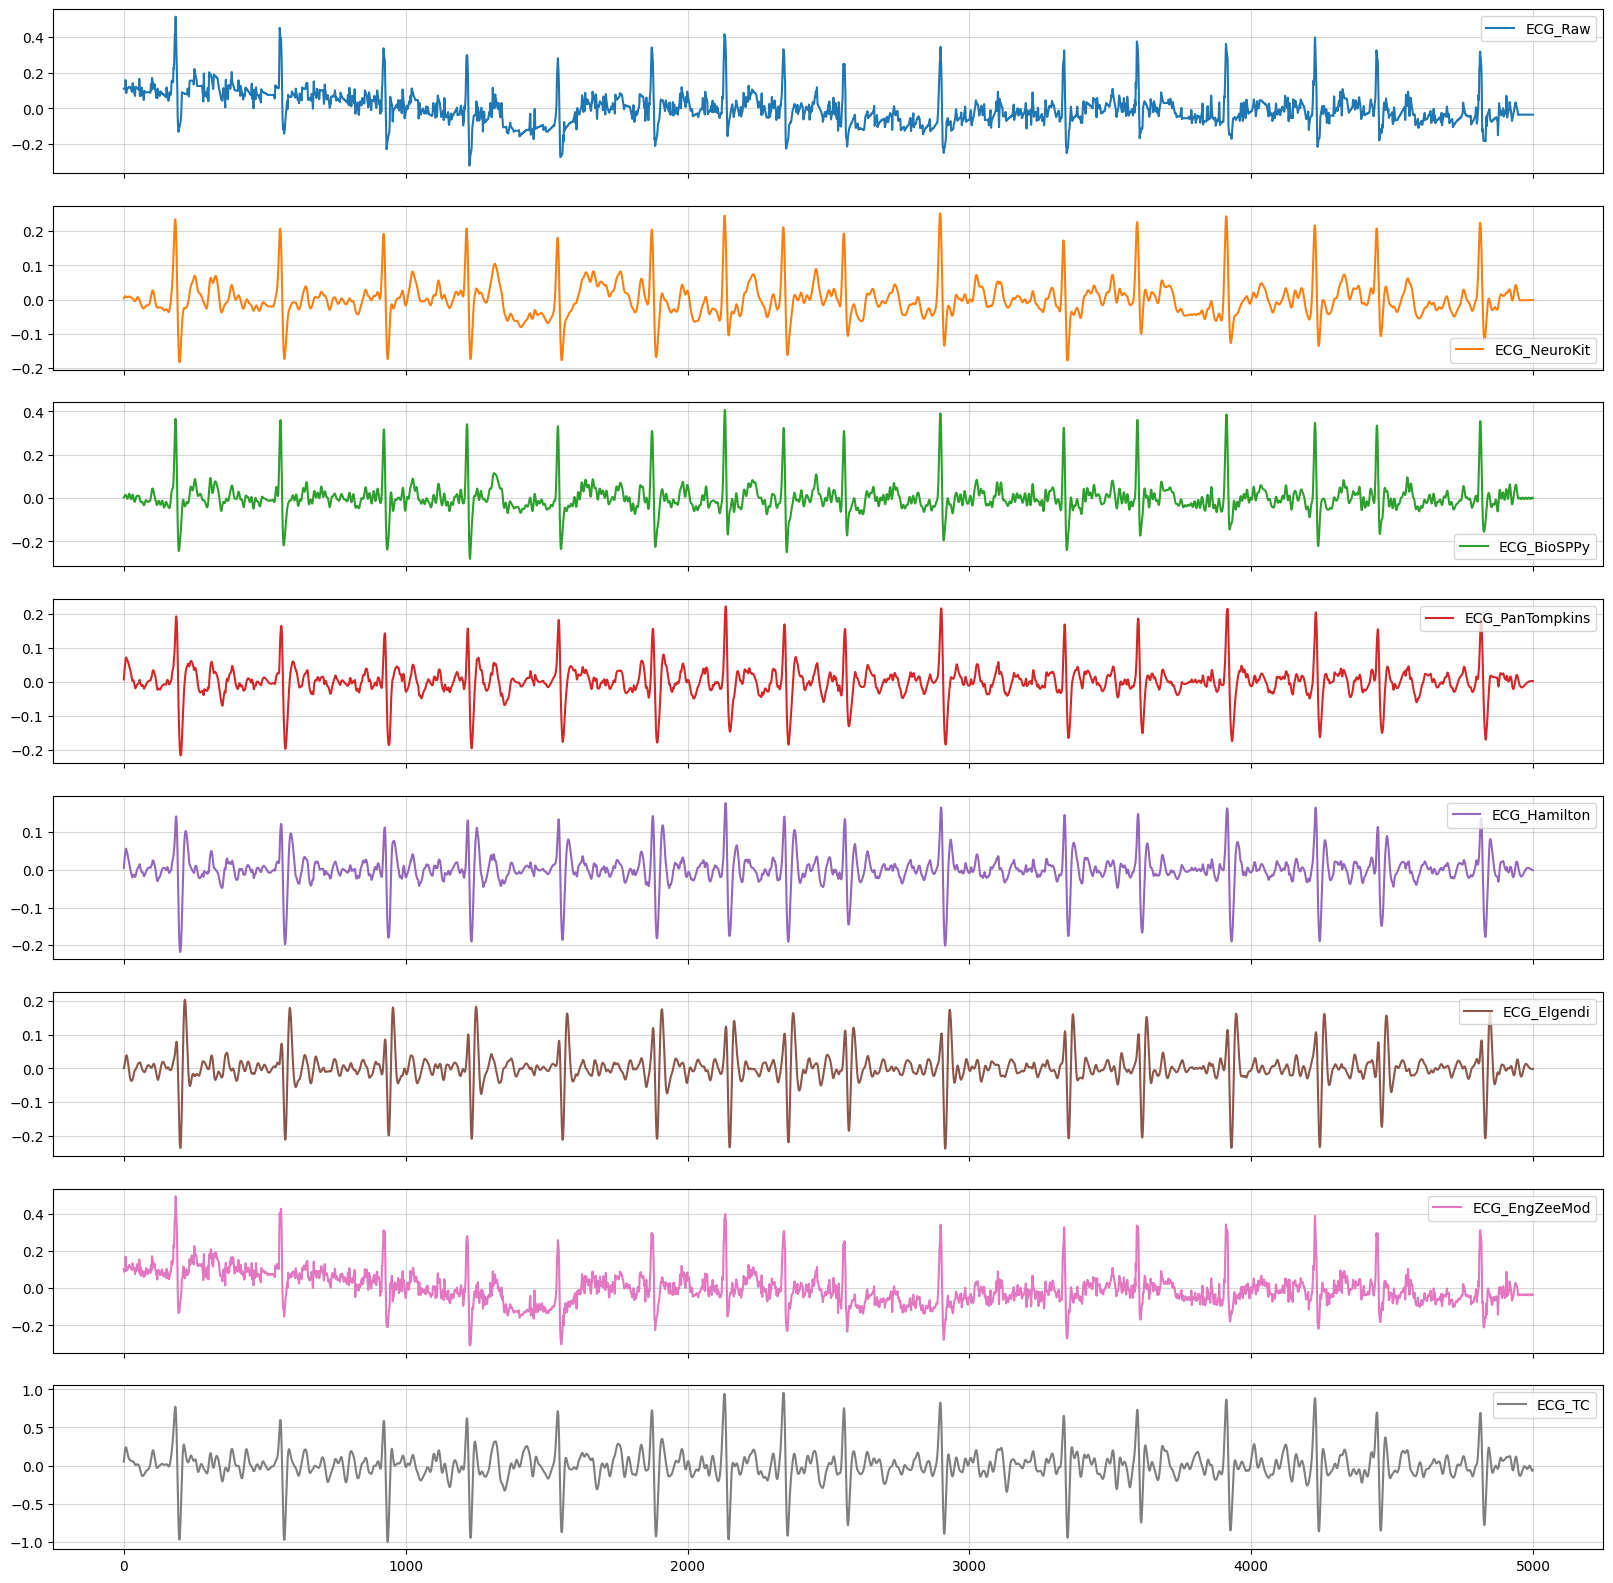

In [23]:
ecg_original = X[12567][:,1]
import neurokit2 as nk
signals = pd.DataFrame({
    "ECG_Raw" : ecg_original,
    "ECG_NeuroKit" : nk.ecg_clean(ecg_original, sampling_rate=500, method="neurokit"),
    "ECG_BioSPPy" : nk.ecg_clean(ecg_original, sampling_rate=500, method="biosppy"),
    "ECG_PanTompkins" : nk.ecg_clean(ecg_original, sampling_rate=500, method="pantompkins1985"),
    "ECG_Hamilton" : nk.ecg_clean(ecg_original, sampling_rate=500, method="hamilton2002"),
    "ECG_Elgendi" : nk.ecg_clean(ecg_original, sampling_rate=500, method="elgendi2010"),
    "ECG_EngZeeMod" : nk.ecg_clean(ecg_original, sampling_rate=500, method="engzeemod2012"),
    "ECG_TC" : nk.ecg_clean(ecg_original, sampling_rate=500, method="templateconvolution")
})


signals.plot(subplots=True)

In [26]:
# Remove all lead noise
# channels = 12
# for index in range(len(X)):
#     for channel in range(channels):
#         X[index][:, channel] = np_move_avg(X[index][:, channel], 5)

In [24]:
import neurokit2 as nk
# Remove all lead noise using neurokit
channels = 12
for index in range(len(X)):
    for channel in range(channels):
        X[index][:, channel] = nk.ecg_clean(X[index][:, channel], sampling_rate=500, method="neurokit")

In [25]:
X.shape

(21837, 5000, 12)

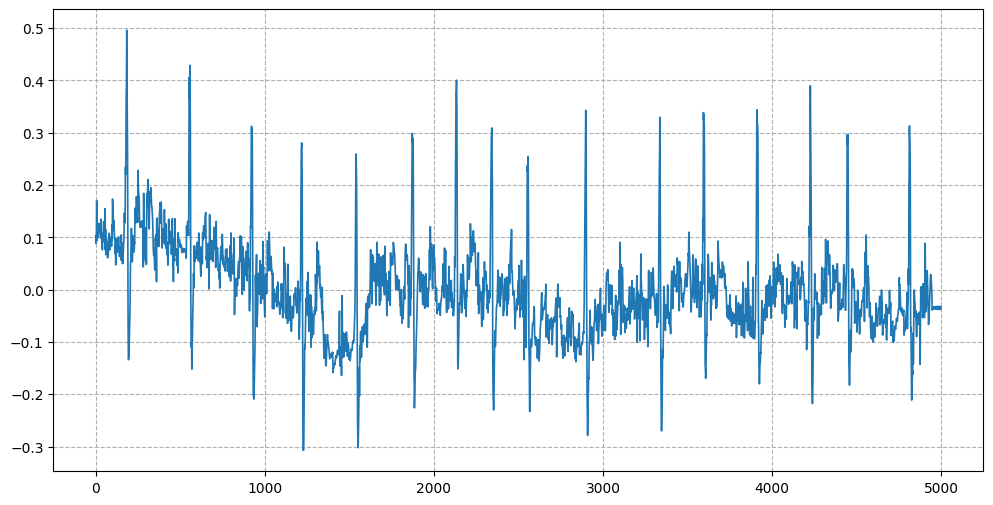

In [26]:
plt.rcParams['figure.figsize'] = (12,6) 
plt.figure()
plt.plot(X[12567][:,1], linewidth=1.2)
plt.grid(linestyle='--')
# plt.yticks([])
plt.show()

## Baseline drift

Use a high-pass filter to remove baseline drift. Baseline drift is a low-frequency interference. The frequency range is usually less than 1Hz, most of which are concentrated at 0.1Hz. It usually appears near the ST segment and Q wave.

The sampling frequency of the signal here is 500Hz. To filter out the baseline drift, obtain the baseline drift through a high-pass filter, and then subtract the baseline drift from the original signal to obtain the ECG signal without baseline drift.

The filter design is as follows:

The cutoff frequency is 0.1Hz, $wn=2*0.1/1000=0.0002$

In [29]:
# b, a = signal.butter(8, 0.01, 'highpass')
# baseline = signal.filtfilt(b, a, ecg_filtered)

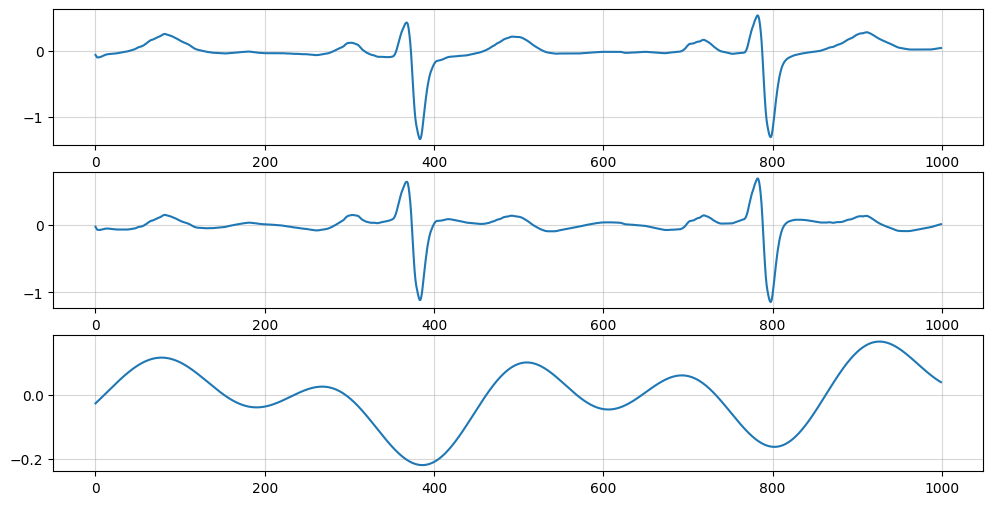

In [30]:
# diff = ecg_filtered-baseline
# plt.figure()
# plt.subplot(311)
# plt.plot(ecg_filtered[:1000])
# plt.subplot(312)
# plt.plot(baseline[:1000])
# plt.subplot(313)
# plt.plot(diff[:1000])
# plt.show()

>The referenced paper did not remove noise. There is no noise removal here. Try to remove baseline drift.

### ECG segmentation extraction

According to the R wave segmentation of the $2$ lead channel of the 12-lead ECG, 150 data before the R wave and 350 data after the R wave

In [26]:
# ecg = X[np.random.randint(len(X))][:,1]
ecg = X[1990][:,1]
ecg.shape

(1000,)

In [27]:
import neurokit2 as nk
ecg = X[1990][:,1]
# ecg.shape

_, rpeaks = nk.ecg_peaks(ecg, sampling_rate=100)
_, waves_peak = nk.ecg_delineate(ecg, rpeaks, sampling_rate=100, method="peak")

In [28]:
rpeaks

{'method_peaks': 'neurokit',
 'method_fixpeaks': 'None',
 'ECG_R_Peaks': array([118, 225, 327, 429, 531, 634, 733, 832, 931]),
 'sampling_rate': 100}

In [29]:
waves_peak

{'ECG_P_Peaks': [100, 210, 312, 399, 515, 617, 715, 815, nan],
 'ECG_Q_Peaks': [115, 221, 323, 425, 527, 626, 730, 828, nan],
 'ECG_S_Peaks': [121, 228, 330, 432, 534, 637, 737, 835, nan],
 'ECG_T_Peaks': [145, 254, 353, 455, 556, 662, 758, 858, nan],
 'ECG_P_Onsets': [96, 208, 296, 396, 504, 612, 701, 804, nan],
 'ECG_T_Offsets': [180, 280, 368, 467, 571, 696, 769, 868, nan]}

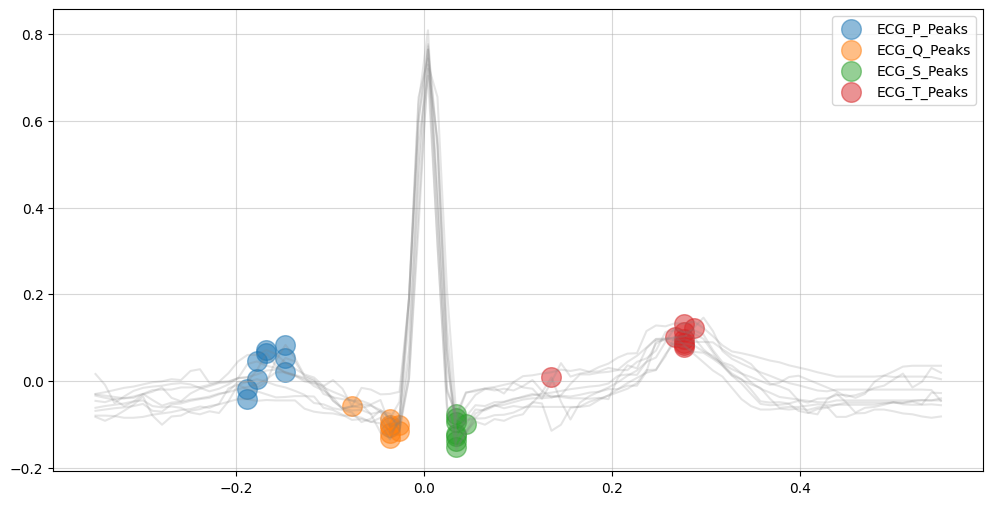

In [30]:
signal_dwt, waves_dwt = nk.ecg_delineate(ecg, 
                                        rpeaks, 
                                        sampling_rate=100, 
                                        method="dwt", 
                                        show=True, 
                                        show_type='peaks')

In [247]:
waves_dwt

{'ECG_P_Peaks': [301,
  717,
  1134,
  1554,
  1970,
  2386,
  2796,
  3200,
  3610,
  4023,
  4426,
  4845],
 'ECG_P_Onsets': [273,
  686,
  1106,
  1530,
  1937,
  2353,
  2764,
  3171,
  3580,
  3993,
  4396,
  4816],
 'ECG_P_Offsets': [327,
  741,
  1157,
  1588,
  1995,
  2408,
  2820,
  3227,
  3632,
  4045,
  4453,
  4871],
 'ECG_Q_Peaks': [345,
  754,
  1180,
  1593,
  2006,
  2431,
  2835,
  3247,
  3655,
  4060,
  4462,
  nan],
 'ECG_R_Onsets': [307,
  721,
  1135,
  1560,
  1974,
  2391,
  2798,
  3238,
  3615,
  4025,
  4433,
  nan],
 'ECG_R_Offsets': [396,
  811,
  1229,
  1651,
  2063,
  2480,
  2891,
  3295,
  3704,
  4117,
  4522,
  nan],
 'ECG_S_Peaks': [383,
  797,
  1216,
  1637,
  2050,
  2466,
  2878,
  3282,
  3690,
  4103,
  4508,
  nan],
 'ECG_T_Peaks': [495,
  909,
  1326,
  1748,
  2161,
  2578,
  2990,
  3393,
  3801,
  4215,
  4619,
  nan],
 'ECG_T_Onsets': [457,
  871,
  1291,
  1719,
  2131,
  2543,
  2927,
  3361,
  3768,
  4178,
  4584,
  nan],
 'ECG_T_O

In [31]:
rpeaks_array = rpeaks['ECG_R_Peaks']
rpeaks_array

array([118, 225, 327, 429, 531, 634, 733, 832, 931])

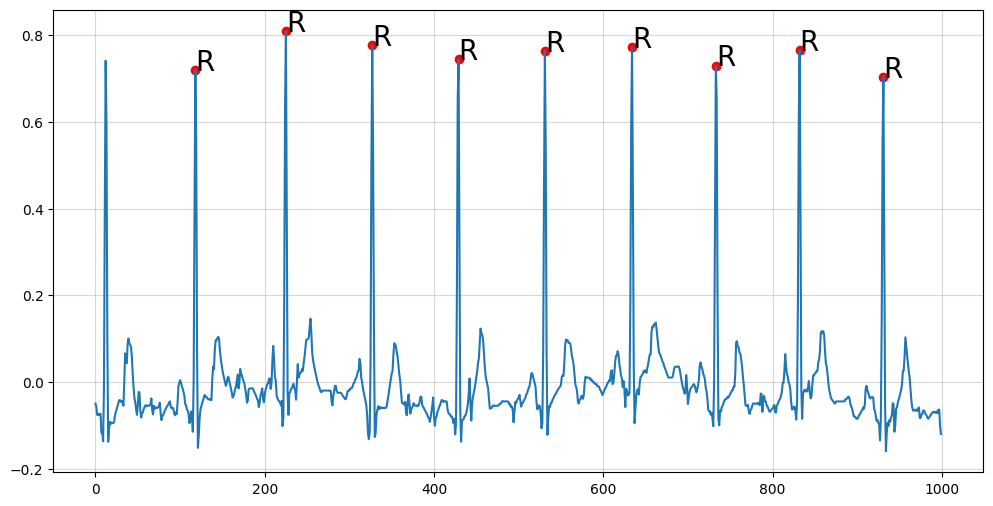

In [32]:
# Check whether R wave detection is correct
# plt.rcParams["axes.grid"] = True
# plt.rcParams["grid.linestyle"] = (0.1,0.1)
plt.figure()
plt.plot(ecg)
for i in range(len(rpeaks_array)):
    plt.scatter(rpeaks_array[i], ecg[rpeaks_array[i]],c='r')
    plt.annotate('R',(rpeaks_array[i], ecg[rpeaks_array[i]]), fontsize=20)
plt.show()

### Segment the signal around the heart beats
You can now epoch all these individual heart beats, synchronized by their R peaks with the ecg_segment() function.
This create a dictionary of dataframes for each ‘epoch’ (in this case, each heart beat).

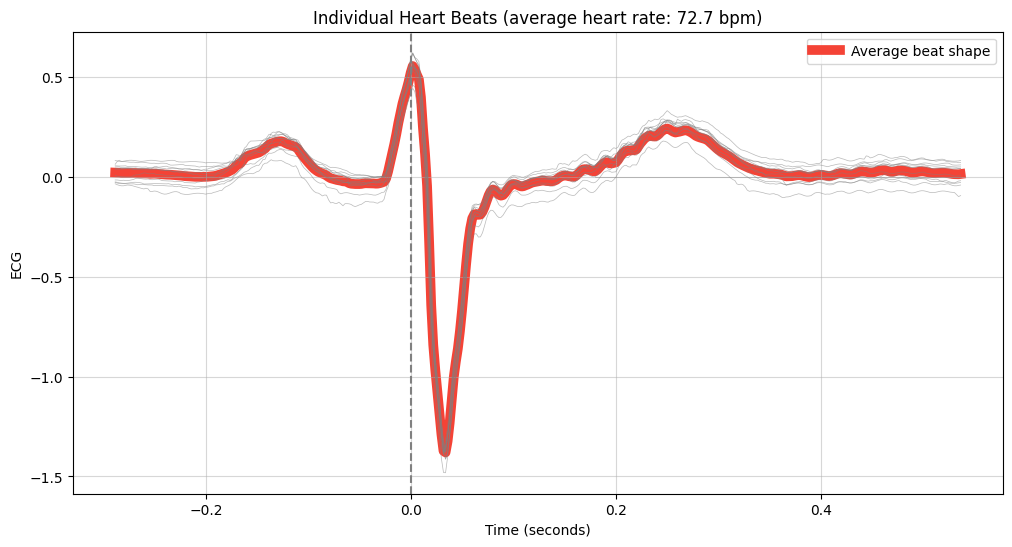

In [39]:
# Plotting all the heart beats
epochs = nk.ecg_segment(ecg, rpeaks=None, sampling_rate=500, show=True)

### Advanced Plotting
This section is written for a more advanced purpose of plotting and visualizing all the heartbeats segments. 

Custom colors and legend
Here, we define a function to create the epochs. It takes in cleaned as the cleaned signal dataframe, and peaks as the array of R-peaks locations.

In [36]:
# Define a function to create epochs
def extract_heartbeats(cleaned, peaks, sampling_rate=None): 
    heartbeats = nk.epochs_create(cleaned, 
                                  events=peaks, 
                                  epochs_start=-0.3, 
                                  epochs_end=0.4, 
                                  sampling_rate=sampling_rate)
    heartbeats = nk.epochs_to_df(heartbeats)
    return heartbeats
    
heartbeats = extract_heartbeats(ecg, peaks=rpeaks_array, sampling_rate=500)
heartbeats.head()

,Signal,Index,Label,Time
0,-0.030639,217,1,-0.300000
1,-0.030628,218,1,-0.297994
2,-0.030376,219,1,-0.295989
3,-0.029986,220,1,-0.293983
4,-0.029612,221,1,-0.291977


We then pivot the dataframe so that each column corresponds to the signal values of one channel, or Label.

In [37]:
heartbeats_pivoted = heartbeats.pivot(index='Time', columns='Label', values='Signal')
heartbeats_pivoted.head()

Label,1,10,11,12,2,3,4,5,6,7,8,9
Time,,,,,,,,,,,,
-0.300000,-0.030639,0.079097,-0.038172,-0.093341,-0.030284,0.061259,0.066943,0.002623,0.041241,0.051518,-0.023142,0.041772
-0.297994,-0.030628,0.078187,-0.036104,-0.095174,-0.026390,0.061601,0.065192,0.003330,0.041629,0.050936,-0.024188,0.040643
-0.295989,-0.030376,0.077935,-0.036859,-0.098610,-0.021372,0.058556,0.064539,0.004572,0.042359,0.050063,-0.024576,0.039329
-0.293983,-0.029986,0.078395,-0.039377,-0.102256,-0.019775,0.055353,0.064112,0.005871,0.042146,0.049258,-0.021530,0.038316
-0.291977,-0.029612,0.079376,-0.035966,-0.104763,-0.017371,0.055811,0.064005,0.006766,0.041149,0.048816,-0.020923,0.037961


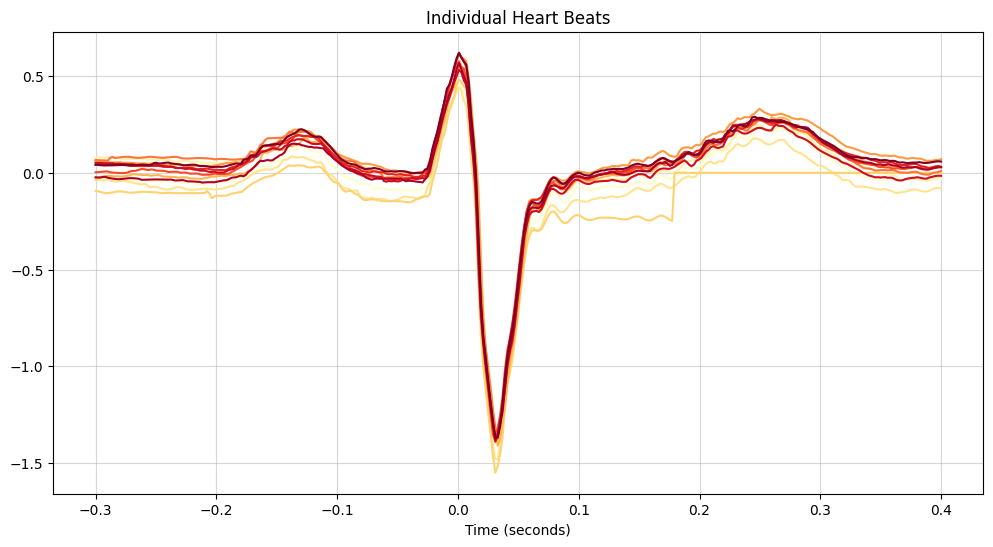

In [38]:
# Prepare figure
fig, ax = plt.subplots()

ax.set_title("Individual Heart Beats")
ax.set_xlabel("Time (seconds)")

# Aesthetics
labels = list(heartbeats_pivoted)
labels = ['Channel ' + x for x in labels] # Set labels for each signal
cmap = iter(plt.cm.YlOrRd(np.linspace(0,1, int(heartbeats["Label"].nunique())))) # Get color map
lines = [] # Create empty list to contain the plot of each signal

for i, x, color in zip(labels, heartbeats_pivoted, cmap):
    line, = ax.plot(heartbeats_pivoted[x], label='%s' % i, color=color)
    lines.append(line)

In [45]:
import neurokit2 as nk
# piecewise function
def splitByR(ecg):
    _, rpeaks = nk.ecg_peaks(ecg, sampling_rate=100)
    _, waves_peak = nk.ecg_delineate(ecg, rpeaks, sampling_rate=100, method="peak")
    index = rpeaks['ECG_R_Peaks']
    ecg_rhythm = None
    for i in range(len(index)):
        # extract a section
        if index[i]>200 and index[i]<1000-350:
            ecg_rhythm = ecg[index[i]-40:index[i]+60]
            continue
    return ecg_rhythm

In [38]:
import neurokit2 as nk
# piecewise function
def splitByR(ecg):
    _, rpeaks = nk.ecg_peaks(ecg, sampling_rate=500)
    _, waves_peak = nk.ecg_delineate(ecg, rpeaks, sampling_rate=500, method="peak")
    index = rpeaks['ECG_R_Peaks']
    ecg_rhythm = None
    for i in range(len(index)):
        # extract a section
        if index[i]>200 and index[i]<1000-350:
            ecg_rhythm = ecg[index[i]-150:index[i]+350]
            continue
    return ecg_rhythm

In [46]:
ecg_rhythm = splitByR(ecg) 


In [47]:
ecg_rhythm.size

100

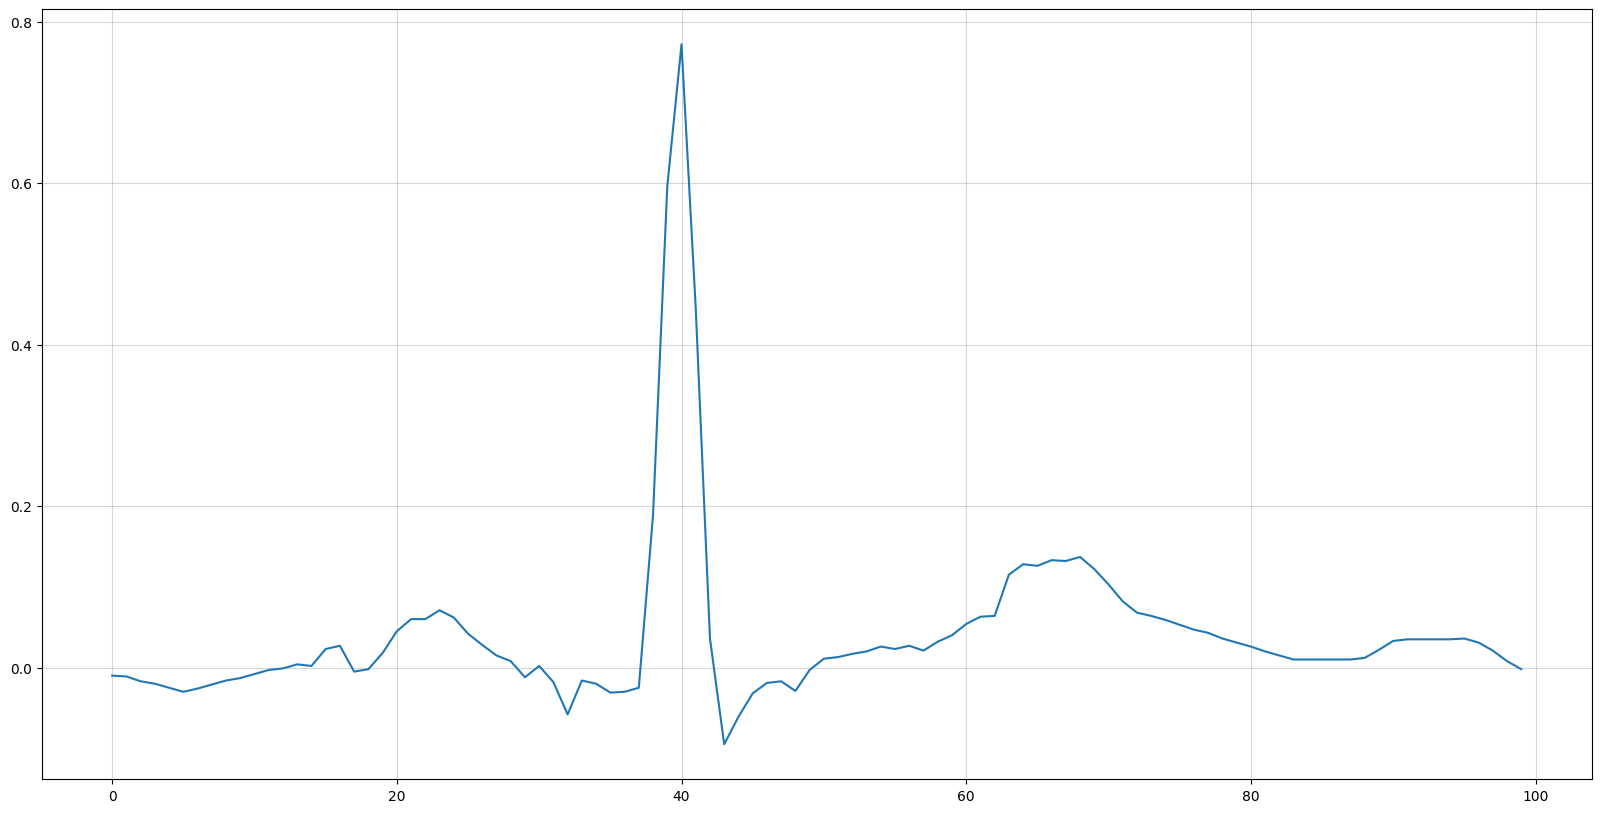

In [48]:

plt.rcParams['figure.figsize'] = (20.0, 10.0)
plt.rcParams["axes.grid"] = True
plt.rcParams["grid.linestyle"] = (0.1,0.1)
plt.rcParams['axes.titlesize'] = 16
plt.figure()
plt.plot(ecg_rhythm)
plt.show()

### ecg_process(ecg_signal, sampling_rate=1000, method='neurokit')
Automated pipeline for preprocessing an ECG signal

This function runs different preprocessing steps: Cleaning (using ecg_clean()), peak detection (using ecg_peaks()), heart rate calculation (using signal_rate()), signal quality assessment (using ecg_quality()), QRS complex delineation (using ecg_delineate()), and cardiac phase determination (using ecg_phase()).

Returns
:
signals (DataFrame) – A DataFrame of the same length as the ecg_signal containing the following columns:

"ECG_Raw": the raw signal.

"ECG_Clean": the cleaned signal.

"ECG_Rate": heart rate interpolated between R-peaks.

"ECG_Quality": the quality of the cleaned signal

"ECG_R_Peaks": the R-peaks marked as “1” in a list of zeros.

"ECG_P_Peaks": the P-peaks marked as “1” in a list of zeros

"ECG_P_Onsets": the P-onsets marked as “1” in a list of zeros.

"ECG_P_Offsets": the P-offsets marked as “1” in a list of zeros.

"ECG_Q_Peaks": the Q-peaks marked as “1” in a list of zeros .

"ECG_R_Onsets": the R-onsets marked as “1” in a list of zeros.

"ECG_R_Offsets": the R-offsets marked as “1” in a list of zeros.

"ECG_S_Peaks": the S-peaks marked as “1” in a list of zeros.

"ECG_T_Peaks": the T-peaks marked as “1” in a list of zeros.

"ECG_T_Onsets": the T-onsets marked as “1” in a list of zeros.

"ECG_T_Offsets": the T-offsets marked as “1” in a list of zeros.

"ECG_Phase_Atrial": cardiac phase, marked by “1” for systole and “0” for diastole.

"ECG_Phase_Completion_Atrial": cardiac phase (atrial) completion, expressed in percentage (from 0 to 1), representing the stage of the current cardiac phase.

"ECG_Phase_Ventricular": cardiac phase, marked by “1” for systole and “0” for diastole.

"ECG_Phase_Completion_Ventricular": cardiac phase (ventricular) completion, expressed in percentage (from 0 to 1), representing the stage of the current cardiac phase.

rpeaks (dict) – A dictionary containing the samples at which the R-peaks occur, accessible with the key "ECG_R_Peaks", as well as the signals’ sampling rate.

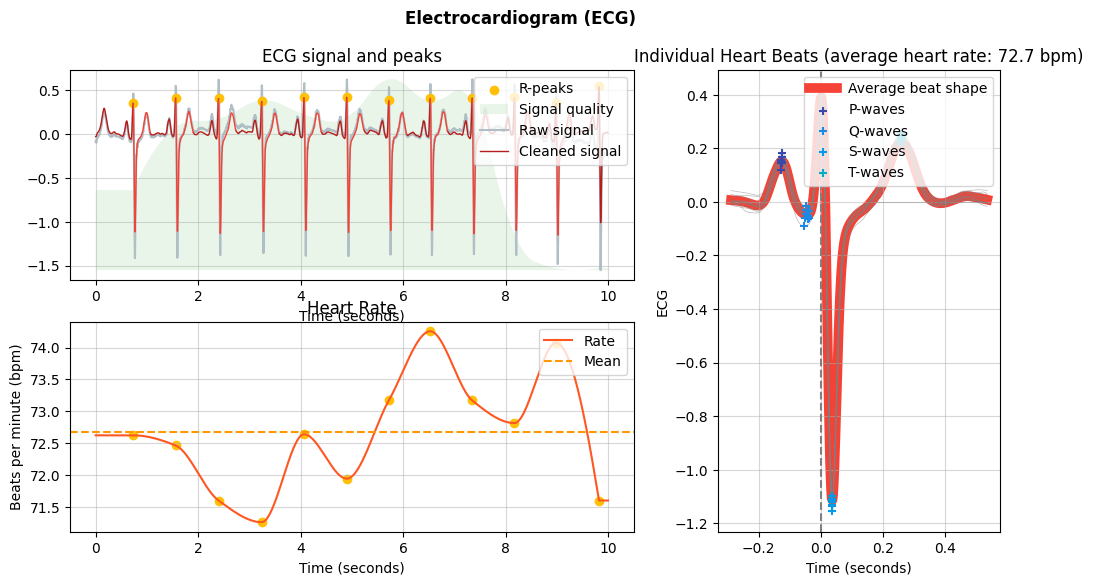

In [42]:
import neurokit2 as nk

# Preprocess ECG signal
signals, info = nk.ecg_process(ecg, sampling_rate=500)

# Visualize
nk.ecg_plot(signals, info)


### ecg_eventrelated()
ecg_eventrelated(epochs, silent=False)
Event-related analysis of ECG

Performs event-related ECG analysis on epochs containing ECG signals.

Returns
:
DataFrame – A dataframe containing the analyzed ECG features for each epoch, with each epoch indicated by the Label column (if not present, by the Index column). The analyzed features consist of the following:

ECG_Rate_Max: the maximum heart rate after stimulus onset.

ECG_Rate_Min: the minimum heart rate after stimulus onset.

ECG_Rate_Mean: the mean heart rate after stimulus onset.

ECG_Rate_SD: the standard deviation of the heart rate after stimulus onset.

ECG_Rate_Max_Time: the time at which maximum heart rate occurs.

ECG_Rate_Min_Time: the time at which minimum heart rate occurs.

ECG_Phase_Atrial: indication of whether the onset of the event concurs with respiratory systole (1) or diastole (0).

ECG_Phase_Ventricular: indication of whether the onset of the event concurs with respiratory systole (1) or diastole (0).

ECG_Phase_Atrial_Completion: indication of the stage of the current cardiac (atrial) phase (0 to 1) at the onset of the event.

ECG_Phase_Ventricular_Completion: indication of the stage of the current cardiac (ventricular) phase (0 to 1) at the onset of the event.

We also include the following experimental features related to the parameters of a quadratic model:

ECG_Rate_Trend_Linear: The parameter corresponding to the linear trend.

ECG_Rate_Trend_Quadratic: The parameter corresponding to the curvature.

ECG_Rate_Trend_R2: the quality of the quadratic model. If too low, the parameters might not be reliable or meaningful.

In [49]:
epochs = nk.epochs_create(signals, events=[1000,2000,3000,4000,5000],
                          epochs_start=-0.1, epochs_end=1.9)


nk.ecg_eventrelated(epochs)

,Label,Event_Onset,ECG_Rate_Baseline,ECG_Rate_Max,ECG_Rate_Min,ECG_Rate_Mean,ECG_Rate_SD,ECG_Rate_Max_Time,ECG_Rate_Min_Time,ECG_Rate_Trend_Linear,ECG_Rate_Trend_Quadratic,ECG_Rate_Trend_R2,ECG_Phase_Atrial,ECG_Phase_Completion_Atrial,ECG_Phase_Ventricular,ECG_Phase_Completion_Ventricular,ECG_Quality_Mean
1,1,1000,72.029045,1.260118,-0.770138,-0.010353,0.533258,1.900000,0.620360,0.009491,-0.473011,0.593034,0.0,0.623229,0.0,0.191837,0.843166
2,2,2000,72.613720,1.643706,-0.671274,0.446382,0.732836,1.264682,0.450275,2.653666,-0.943641,0.539447,1.0,0.483871,0.0,0.867220,0.866073
3,3,3000,73.639811,0.617615,-1.930238,-0.201188,0.565697,0.264182,1.900000,-1.287714,0.507703,0.253112,0.0,0.411765,1.0,0.809249,0.479384
4,4,4000,72.837005,1.237069,-72.837005,-34.371882,36.513616,0.491296,1.000550,-43.139248,15.873044,0.755025,0.0,0.936782,0.0,0.654472,0.039275
5,5,5000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001051,0.001051,0.000000,0.000000,1.000000,0.0,0.000000,0.0,0.000000,-0.000003


Segmentation of ECG data: Centered around the R-wave peaks of Lead 2. 

1. The code first identifies the R-wave peaks in each ECG signal using the `detect_r_peaks` function. The R-wave is a prominent feature in an ECG signal that corresponds to the depolarization of the ventricles of the heart.

2. Once the R-wave peaks are identified, the code checks if each R-wave peak is within a specific range. The condition `if R_index[i]>200 and R_index[i]<1000-350` ensures that the R-wave peak is not too close to the beginning or the end of the signal.

3. If an R-wave peak meets the specified condition, the code extracts a segment of ECG data. The extracted segment includes data points from 150 samples before the R-wave peak to 350 samples after the R-wave peak, effectively creating a segment centered around the R-wave.

4. These extracted segments are then stored in the `ecg_rhythms` array. Each row of the `ecg_rhythms` array corresponds to an ECG signal, and each column corresponds to a channel (lead) of the ECG. Therefore, the `ecg_rhythms` array contains multiple segments, each centered around an R-wave peak and spanning all 12 ECG channels.

The code is extracting segments of ECG data that capture the cardiac activity centered around the R-wave peaks, which are crucial landmarks in ECG signals for various types of cardiac analysis and processing.

In [50]:
import neurokit2 as nk
# Extract segments from all channels of all signals
channels = 12
test_size = len(X)
ecg_rhythms = np.zeros([test_size, 100, 12])

# Create an array to store all R-peak locations for your dataset
R_indices = []

start_time = time.time()
first_time = start_time
for index in range(test_size):
    if index%1000 == 0:
        end_time = time.time()
        print("finish %d in %d s\n" % (index, end_time - start_time))
        start_time = time.time()
    # Extract R-peak indices for the current ECG using nk.ecg_peaks
    _, rpeaks = nk.ecg_peaks(X[index][:, 1], sampling_rate=100)
    R_index = rpeaks['ECG_R_Peaks']
    for i in range(len(R_index)):
        # extract a section
        if R_index[i]>200 and R_index[i]<1000-350:
            ecg_rhythms[index][:, :] = X[index][R_index[i]-40:R_index[i]+60,:]
            continue

end_time = time.time()

print('time cost:%d s'%(end_time-first_time))

finish 0 in 0 s

finish 1000 in 1 s

finish 2000 in 1 s

finish 3000 in 1 s

finish 4000 in 1 s

finish 5000 in 1 s

finish 6000 in 0 s

finish 7000 in 1 s

finish 8000 in 1 s

finish 9000 in 0 s

finish 10000 in 0 s

finish 11000 in 0 s

finish 12000 in 0 s

finish 13000 in 0 s

finish 14000 in 0 s

finish 15000 in 0 s

finish 16000 in 0 s

finish 17000 in 0 s

finish 18000 in 0 s

finish 19000 in 1 s

finish 20000 in 1 s

finish 21000 in 1 s

time cost:23 s


In [50]:
import neurokit2 as nk
# Extract segments from all channels of all signals
channels = 12
test_size = len(X)
ecg_rhythms = np.zeros([test_size, 500, 12])

# Create an array to store all R-peak locations for your dataset
R_indices = []

start_time = time.time()
first_time = start_time
for index in range(test_size):
    if index%1000 == 0:
        end_time = time.time()
        print("finish %d in %d s\n" % (index, end_time - start_time))
        start_time = time.time()
    # Extract R-peak indices for the current ECG using nk.ecg_peaks
    _, rpeaks = nk.ecg_peaks(X[index][:, 1], sampling_rate=500)
    R_index = rpeaks['ECG_R_Peaks']
    for i in range(len(R_index)):
        # extract a section
        if R_index[i]>200 and R_index[i]<1000-350:
            ecg_rhythms[index][:, :] = X[index][R_index[i]-150:R_index[i]+350,:]
            continue

end_time = time.time()

print('time cost:%d s'%(end_time-first_time))

finish 0 in 0 s

finish 1000 in 2 s

finish 2000 in 2 s

finish 3000 in 2 s

finish 4000 in 4 s

finish 5000 in 5 s

finish 6000 in 2 s

finish 7000 in 3 s

finish 8000 in 4 s

finish 9000 in 4 s

finish 10000 in 7 s

finish 11000 in 4 s

finish 12000 in 3 s

finish 13000 in 2 s

finish 14000 in 3 s

finish 15000 in 3 s

finish 16000 in 2 s

finish 17000 in 2 s

finish 18000 in 5 s

finish 19000 in 4 s

finish 20000 in 3 s

finish 21000 in 3 s

time cost:83 s


In [51]:
ecg_rhythms.shape

(21837, 100, 12)

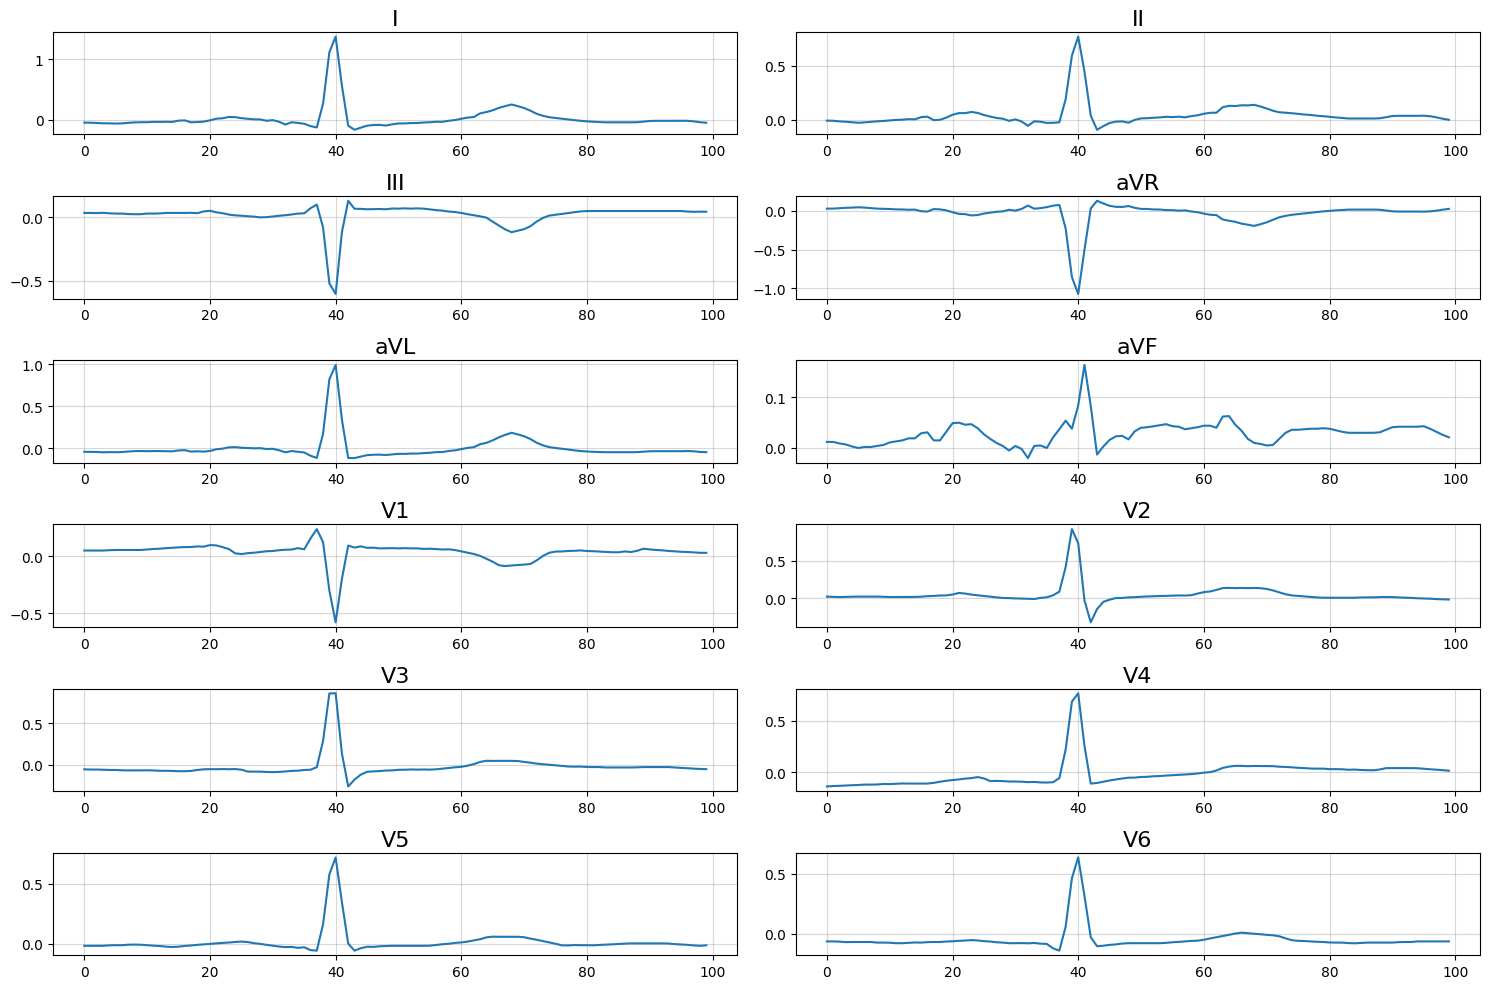

In [57]:
titles = ["I", "II", "III", "aVR", "aVL", "aVF", "V1", "V2", "V3", "V4", "V5", "V6"]

plt.figure(figsize=(15, 10))  # Adjust figure size if needed
for i in range(12):
    plt.subplot(6, 2, i+1)
    plt.plot(ecg_rhythms[1990, :, i])
    plt.title(titles[i], pad=5)  # Adjust pad value to adjust space between title and subplot
plt.tight_layout()  # Ensures tight layout
plt.show()


In [39]:
# false_count = 0
# Y['Runconfirmed'] = 0
# for index in range(len(ecg_rhythms)):
#     if ecg_rhythms[index].any() == np.zeros([500, 12]).any():
#         false_count += 1
#         Y['Runconfirmed'][index] = 1
# false_count

C:\Users\ROG\AppData\Local\Temp\ipykernel_2584\2216112086.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y['Runconfirmed'][index] = 1


2598


## Divide the data set

In [55]:
# Split data into train and test
test_fold = 10
# # Train
X_train = ecg_rhythms[(Y.strat_fold <= 8)]
y_train = Z[Y.strat_fold <= 8]
# # Test
X_test = ecg_rhythms[(Y.strat_fold >8)]
y_test = Z[Y.strat_fold > 8]

print(X_train.shape, y_train.shape)
print(X_test.shape,  y_test.shape)

(17441, 500, 12) (17441, 5)
(4396, 500, 12) (4396, 5)


In [56]:
save_path = 'D:/Test Jupyter/ECG-Classfier-main/data/numpy_data/'

np.save(save_path+'X_train.npy', X_train)
np.save(save_path+'y_train.npy', np.array(y_train))
np.save(save_path+'X_test.npy', X_test)
np.save(save_path+'y_test.npy', np.array(y_test))

In [57]:
y_test

,NORM,MI,STTC,CD,HYP
ecg_id,,,,,
8,0,1,0,0,0
9,1,0,0,0,0
10,1,0,0,0,0
17,0,0,0,0,0
18,0,0,0,0,0
...,...,...,...,...,...
21818,1,0,0,0,0
21819,0,0,0,1,0
21826,0,1,0,0,0


In [58]:
distinct_values_counts = y_train.value_counts()
print(distinct_values_counts)

NORM  MI  STTC  CD  HYP
1     0   0     0   0      7254
0     1   0     0   0      2048
      0   1     0   0      1907
          0     1   0      1353
      1   0     1   0      1038
      0   1     0   1       650
      1   1     0   0       475
      0   0     0   1       416
          1     1   0       387
          0     0   0       330
1     0   0     1   0       327
0     1   1     0   1       282
      0   0     1   1       235
      1   1     1   0       177
      0   1     1   1       168
      1   0     0   1       146
          1     1   1       123
          0     1   1        99
1     0   1     0   0        20
                1   0         4
          0     0   1         1
      1   0     1   1         1
dtype: int64
